Note: this notebook users conda environment: genderenv

#### Warning: do not use the file conversion here - it does not preserve page numbering reliably. Please use docto (see script: convert_all.py)

#### Note on naming: books names were taken from the directory names in 'Books'. This was occasionally inconsistent with the names in the excel spreadsheet. Usually this was due to punctuation (?!,:etc), capitalisation, or subtitle exclusion (e.g. 'a book about being nice' etc). This is worth remembering when trying to link to new book lists from new schools.

In [1]:
CONVERT_DOCS = True  # Whether to convert doc files to pdf.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pdfplumber
import os 
import subprocess

%matplotlib inline

#### First we convert all doc files to pdf with:
 
libreoffice --headless --convert-to pdf Careful\ Santa\!.doc --outdir ./test.pdf

Note: tried docx2txt and docx2python but both required conversion from doc to docx first (which did not preserve formatting) and also docx does not contain page information (this is handled on rendering) meaning that relevant pages could not easily be selected.

In [3]:
if CONVERT_DOCS:

    os.chdir('../Books')

    for b in os.listdir():
        print(b)
        os.chdir(b)
        file_list = os.listdir()

        found = False
        for file in file_list:
            if file[-4:] == '.doc' or file[-5:] == '.docx':
                print(file)
                found = True
                subprocess.call(["libreoffice",
                     "--headless",
                     "--convert-to",
                     "pdf",
                     file,
                     "--outdir", 
                     "../../text_pdfs/"])
        if not found:
            print("WARNING: FILE NOT CONVERTED! ^")
        os.chdir('..')

No-Bot
No-Bot.doc
Santa is Coming to Devon
Santa is Coming to Devon.doc
All Year Round
All Year Round.doc
Keith The Cat With The Magic Hat
Keith The Cat With The Magic Hat.doc
Ten in the Bed and Other Counting Rhymes
Ten in the Bed and Other Counting Rhymes.doc
Sir Charlie Stinky Socks and the Really Big Adventure
Sir Charlie Stinky Socks and the Really Big Adventure.doc
Barry the Fish With Fingers and the Hairy Scary Monster
Barry the Fish With Fingers and the Hairy Scary Monster.doc
The Christmas Extravaganza Hotel
The Christmas Extravaganza Hotel.doc
Elmer and the Stranger
Elmer and the Stranger.doc
Open Very Carefully. A Book With Bite!
Open Very Carefully, A Book With Bite!.doc
Room on the Broom
Room on the Broom.doc
The Cross Rabbit
The Cross Rabbit.doc
Lion's in a Flap
Lion's in a Flap.doc
Harry and the Dinosaurs Go Wild
Harry and the Dinosaurs Go Wild.doc
The Rescue Party
The Rescue Party.doc
Elmer and the Lost Teddy
Elmer and the Lost Teddy.doc
The Hungry Caterpillar
The Hungr

#### Now we can grab the text from the pdf files:

Note: need to record what page the main text starts and end (at the moment we are grabbing everything including authors, publication details, summary).

In [4]:
#labels = pd.read_excel('../Book List Exel April.xlsx', sheet_name='Sheet1')
labels = pd.read_excel('../Book List Clean Titles.xlsx', sheet_name='Sheet1')
labels = labels.rename(columns={'Author ': 'Author'})

In [5]:
os.chdir('../text_pdfs/')

In [6]:
df = pd.DataFrame()

def grab_text(title, labels):
    
    start = labels.loc[labels.Title==title]['Starting Page']
    if len(start)==0:
        print(title, "no start")
        start = 0
    else:
        start = start.values[0]
    end = labels.loc[labels.Title==title]['Ending Page']
    if len(end)==0:
        print(title, "no end")
        end = 0
    else:
        end = end.values[0]
    
    title = title + '.pdf'
    all_text = ''
    with pdfplumber.open(title) as pdf:
        for i, page in enumerate(pdf.pages):
            if i+1 >= start and i < end:
                single_page_text = page.extract_text()

                if single_page_text is not None:
                    all_text = all_text + '\n' + single_page_text
                
    return all_text

df['Title'] = [file.split('.')[0] for file in os.listdir() if file.split('.')[1]=='pdf']
df['Text'] = [grab_text(title, labels) for title in df.Title]

In [7]:
df.head()

,Title,Text
0,The Night Before Christmas,\n'Twas the night before Christmas\nwhen all t...
1,The Gruffalo,\nA mouse took a stroll through the deep dark ...
2,The Monstrous Tale of Celery Crumble,\nHave you met Celery Crumble?\nThat’s her rig...
3,Peace at Last,"\nThe hour was late.\nMr Bear was tired, Mrs B..."
4,Barry The Fish With Fingers,"\nPuffy the puffer fish, could blow\nthe BEST ..."


In [8]:
print(len(df))

129


#### Let's check out the summary information from the excel spreadsheet:

In [9]:
labels = labels.dropna(subset=['Protagonist Gender'])

In [10]:
labels.head(2)

,Number,AW Has,Title,Author,Cost,Source,Starting Page,Ending Page,Protagonist Gender,Protagonist Human/ Non-human,Protagonist Name,Secondary Character Gender,SC Human/Non Human,SC Names,Notes,Year of First Publication,Unnamed: 16,Unnamed: 17,Unnamed: 18
1,2.0,NaN,Owl Babies,Martin Waddell,2.75,ebay,6.0,29.0,F/M/M,NH,Sarah/Percy/Bill,F,NH,Owl Mother,NaN,NaN,NaN,NaN,NaN
2,3.0,Yes,Where's My Teddy,Jez Alborough,NaN,NaN,6.0,29.0,M,H,Eddy,M,NH,NaN,NaN,NaN,NaN,NaN,NaN


#### This gives us a crude way of plotting the gender of the protagonists:

#### Note: check the 'gender_map'. Is 'NA' NGS?

In [11]:
def plot_gender_freqs(df, normalise=False, title=None):
    
    denominator = len(df) if normalise else 1
    
    plt.hist(df['Protagonist Gender'], 
            bins=np.arange(1 + len(df['Protagonist Gender'].unique())) - 0.5,
            weights=[1/denominator for i in df.Number])
    plt.xticks(rotation=90)
    plt.ylabel('frequency')
    
    title = 'Protagonist Gender' if title is None else title
    plt.title(title);

In [12]:
gender_map = {
    'M':'M',
    'M  ':'M',
    'M ':'M',
    'M PLURAL ': 'M', 
    'M/M': 'M',
    'F/M': 'B',
    'F/M/M': 'B', 
    'NGS SINGULAR AND PLURAL': 'N',
    'NGS': 'N', 
    'NGS/NGS ': 'N',
    'NGS PLURAL': 'N', 
    'F': 'F', 
    'NGS MANY': 'N',
    'M/NGS/NGS/NGS/NGS': 'M/NGS/NGS/NGS/NGS', # Not sure about this one 
    'PLURAL NGS': 'N',
    'NGS FIRST PERSON': 'N',
    'F/F/F/M/M/M/M/M PLURAL': 'B',
    'NA ': 'NA',
    'M/F/F/M/F/M/F/F/M': 'B',
    'NA 2nd Person': 'NA',
    'M/F ': 'B',
    '2nd person voice/NGS': 'NGS',
    'NA plural': 'NA',
    'F ': 'F',
    'NA First Person': 'NA',
    'M/F': 'B',
    'Many NGS': 'N',
    'he Way': 'N',
    'F/F/F/M/M/M/M PLURAL': 'B'
}

In [13]:
#str(labels.loc[labels['Protagonist Gender']=='NA plural'].Notes.values)
labels.loc[labels['Protagonist Gender']=='he Way']

,Number,AW Has,Title,Author,Cost,Source,Starting Page,Ending Page,Protagonist Gender,Protagonist Human/ Non-human,Protagonist Name,Secondary Character Gender,SC Human/Non Human,SC Names,Notes,Year of First Publication,Unnamed: 16,Unnamed: 17,Unnamed: 18


In [14]:
labels_agg_gender = labels.copy()
labels_agg_gender['Protagonist Gender'] = [gender_map[g] for g in labels_agg_gender['Protagonist Gender']]
labels_agg_gender['Protagonist Human/ Non-human'] = [h if h!='H ' else 'H' for h in labels_agg_gender['Protagonist Human/ Non-human']]

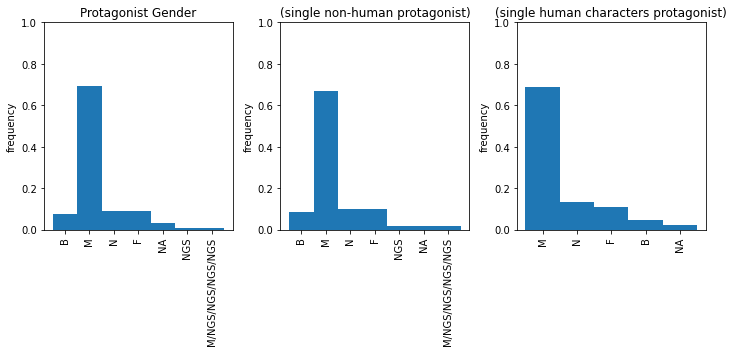

In [15]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plot_gender_freqs(labels_agg_gender, normalise=True)
plt.ylim([0,1.0])

plt.subplot(1,3,2)
plot_gender_freqs(
    labels_agg_gender.loc[labels_agg_gender['Protagonist Human/ Non-human'] == 'NH'],
    normalise=True,
    title='(single non-human protagonist)' 
)
plt.ylim([0,1.0])

plt.subplot(1,3,3)
plot_gender_freqs(
    labels_agg_gender.loc[labels_agg_gender['Protagonist Human/ Non-human'] == 'H'],
    normalise=True,
    title='(single human characters protagonist)' 
)
plt.ylim([0,1.0])


plt.tight_layout()

In [16]:
def count_table(df, column):
    return (
        df.groupby(column)
        .agg({'Number':'count'})
        .rename(columns={'Number':'count'})
        .sort_values(by='count', ascending=False)
    )

In [17]:
count_table(labels, 'Protagonist Gender')
#count_table(labels.loc[labels['Protagonist Human/ Non-human'] == 'NH'], 'Protagonist Gender')
#count_table(labels, 'Protagonist Human/ Non-human')

,count
Protagonist Gender,
M,79
F,10
M/M,7
F/M,4
NGS PLURAL,4
NGS,3
F,2
M,2
M/F,2


#### We can also count the genders of all characters (conditioned on H/NH if desired):

#### Note: this count plural characters (e.g. 'the cavemen': NGS PLURAL) as a single character, which is appropriate for e.g. normalisation of speech counts ('the cavemen said "..."').

In [18]:
male_genders = ['M', 'M PLURAL ', 'M  ', 'M ', 'M PLURAL']
female_genders = ['F', 'F ']
ngs_genders = ['NGS SINGULAR AND PLURAL', 'NGS', 'NGS PLURAL', 'NGS, PLURAL', 'MANY NGS',
               'NGS MANY', 'PLURAL NGS', 'NGS ', 'NGS FIRST PERSON', 'Many NGS']

for key in gender_map.keys():
    for i in key.split('/'):
        if i not in male_genders + female_genders + ngs_genders:
            print(i)

NA 
NA 2nd Person
2nd person voice
NA plural
NA First Person
he Way


In [19]:
male_count = {'H': 0, 'NH': 0}
female_count = {'H': 0, 'NH': 0}
ngs_count = {'H': 0, 'NH': 0}

for gender,species in zip(labels['Protagonist Gender'], labels['Protagonist Human/ Non-human']):
    
    if isinstance(gender, float) or  isinstance(species, float):
        continue
        
    _genders = gender.split('/')
    _species = species.split('/')
    
    
    if len(_species) != len(_genders):
        # replace for cases like: 'F/M/M', 'NH' (Owl Babies)
        if len(_species) == 1:
            _species = [_species[0] for g in _genders]
        
        # replace for cases like: 'M PLURAL', 'NH/H' (Dinosaurs Love Underpants)
        elif len(_genders) == 1:
            _genders = [_genders[0] for g in _species]
        else:
            print('Warning: list length mismatch: ', _genders, _species)
            break
    
    for g,s in zip(_genders, _species):
        if g in female_genders:
            female_count[s.strip()] += 1
        elif g in male_genders:
            male_count[s.strip()] += 1
        elif g in ngs_genders:
            ngs_count[s.strip()] += 1
        else:
            print('Warning: %s not in a gender list.' % g)

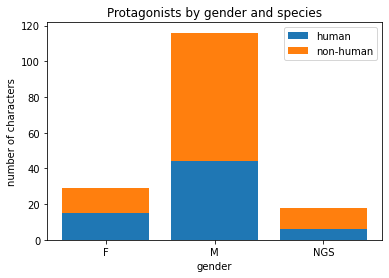

In [20]:
plt.bar(['F', 'M', 'NGS'], [female_count['H'], male_count['H'], ngs_count['H']], label='human');
plt.bar(['F', 'M', 'NGS'], 
        [female_count['NH'], male_count['NH'], ngs_count['NH']], 
        bottom=[female_count['H'], male_count['H'], ngs_count['H']],
        label='non-human');

plt.legend()
plt.xlabel('gender')
plt.ylabel('number of characters')
plt.title('Protagonists by gender and species');

#### Now adding secondary/minor characters:

In [21]:
sc_male_count = {'H': 0, 'NH': 0}
sc_female_count = {'H': 0, 'NH': 0}
sc_ngs_count = {'H': 0, 'NH': 0}

for gender,species in zip(labels['Secondary Character Gender'], labels['SC Human/Non Human']):
    
    if isinstance(gender, float) or isinstance(species, float):
        continue
    else:
        _genders = gender.split('/')
        _species = species.split('/')

        if len(_species) != len(_genders):
            # replace for cases like: 'F/M/M', 'NH' (Owl Babies)
            if len(_species) == 1:
                _species = [_species[0] for g in _genders]

            # replace for cases like: 'M PLURAL', 'NH/H' (Dinosaurs Love Underpants)
            elif len(_genders) == 1:
                _genders = [_genders[0] for g in _species]
            else:
                print('Warning: list length mismatch: ', _genders, _species)
                break
                #continue

        for g,s in zip(_genders, _species):
            if g.strip() in female_genders:
                sc_female_count[s.strip()] += 1
            elif g.strip() in male_genders:
                sc_male_count[s.strip()] += 1
            elif g.strip() in ngs_genders:
                sc_ngs_count[s.strip()] += 1
            else:
                print('Warning: %s not in a gender list.' % g)

In [22]:
labels['Secondary Character Gender'].unique()

array(['F', 'M', 'NGS', 'M/F/M/', 'M ', 'M/M/F', 'NGS/NGS/M', nan,
       'M/NGS', 'M/M/M/M/M', 'M/F/M', 'NGS/M', 'F/M', 'M/M/M ',
       'M/F/M/NGS/NGS', 'M/M/M', 'F/F/NGS/NGS/NGS', 'M/F/F', 'F/F/F',
       'F/M/F/M', 'F/F/F/M', 'F/F/F/F/M', 'F/F/M/M', 'M/M/M/F/NGS', 'M/M',
       'M/M/M/M', 'F/F', 'F/M/M/F/M',
       'M/F/M/M/F/M/F/F/F/F/M/F/F/M/F/F/M/F/',
       'M/NGS/NGS/NGS/NGS/NGS/NGS/NGS/NGS/NGS', 'M/F/NGS/F',
       'M/M/F/F/NGS', 'F/M/M/F/NGS', 'F/M/M/F/M/F/M', 'MANY NGS',
       'M/NGS ', 'F/NGS/NGS/NGS', 'NGS/NGS/NGS/NGS', 'M/F/F/M',
       'F/NGS/NGS PLURAL/NGS', 'NGS PLURAL/F', 'NGS, PLURAL', 'M/F ',
       'M/F', 'F/M/M/M/M/NGS', 'M/M/F/M/F', 'F/F/M', 'NGS/NGS/F',
       'M/M/M/F/F', 'M/M/M/F', 'NGS/M/M/NGS/M/M/F/F', 'M/NGS/NGS/NGS',
       'F/M/M/F'], dtype=object)

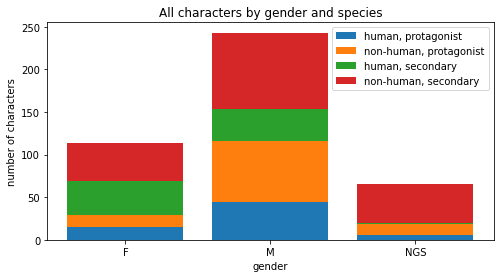

In [23]:
plt.figure(figsize=(8,4))
plt.bar(['F', 'M', 'NGS'], [female_count['H'], male_count['H'], ngs_count['H']], label='human, protagonist');

baseline = [female_count['H'], male_count['H'], ngs_count['H']]
plt.bar(['F', 'M', 'NGS'], 
        [female_count['NH'], male_count['NH'], ngs_count['NH']], 
        bottom=baseline,
        label='non-human, protagonist');

baseline[0] += female_count['NH']
baseline[1] += male_count['NH']
baseline[2] += ngs_count['NH']
plt.bar(['F', 'M', 'NGS'], 
        [sc_female_count['H'], sc_male_count['H'], sc_ngs_count['H']], 
        bottom=baseline,
        label='human, secondary');

baseline[0] += sc_female_count['H']
baseline[1] += sc_male_count['H']
baseline[2] += sc_ngs_count['H']
plt.bar(['F', 'M', 'NGS'], 
        [sc_female_count['NH'], sc_male_count['NH'], sc_ngs_count['NH']], 
        bottom=baseline,
        label='non-human, secondary');

plt.legend()
plt.xlabel('gender')
plt.ylabel('number of characters')
plt.title('All characters by gender and species');
#plt.ylim([0,130]);    

In [24]:
sum(sc_female_count.values())

85

In [33]:
sum(sc_male_count.values()) / (sum(sc_male_count.values()) + sum(male_count.values()))

0.522633744855967

In [32]:
sum(sc_female_count.values()) / (sum(sc_female_count.values()) + sum(female_count.values()))

0.7456140350877193

In [29]:
sum(female_count.values()) + sum(sc_female_count.values())

114

In [30]:
sum(male_count.values()) + sum(sc_male_count.values())

243

In [31]:
114 / (114 + 243)

0.31932773109243695

#### Now we can link to the summary information from the excel spreedsheet:

In [33]:
df = df.merge(
    labels[['Title', 'Author', 'Protagonist Gender', 'Protagonist Human/ Non-human', 'Secondary Character Gender', 'SC Human/Non Human']],
    on='Title',
    how='left'
)

In [34]:
df

,Title,Text,Author,Protagonist Gender,Protagonist Human/ Non-human,Secondary Character Gender,SC Human/Non Human
0,The Gruffalo,\nA mouse took a stroll through the deep dark ...,Julia Donaldson,M,NH,M/M/M/M,NH
1,Peace at Last,\n \nThe hour was late. \n \nMr Bear was tired...,Jill Murphy,M,NH,F/M,NH
2,Kipper's Toybox,\nSomeone or something had been \nnibbling a h...,Mick Inkpen,M,NH,M,NH
3,The Hungry Caterpillar,\n \nIn the light of the moon a little egg lay...,Eric Carle,M,NH,NaN,NaN
4,Harry and the Dinosaurs Go Wild,\nIt was a long drive to the safari park but i...,Ian Whybrow and Adrian Reynolds,M,H,F/F/F/M,H
...,...,...,...,...,...,...,...
65,One Snowy Night,\n \nIt’s cold in the park in winter.\n \nBut ...,Nick Butterworth,M,H,NGS/NGS/M,NH
66,The Squirrels Who Squabbled,"\nIn a towering forest, where summer had been,...",Rachel Bright and Jim Field,M/M,NH,NaN,NaN
67,The Truth According to Arthur,\nThis is\n \nArthur.\n \nAnd this is\n \nThe ...,Tim Hopgood,M,H,M/F/NGS/F,H
68,Monkey Puzzle,"\n \n“I’ve lost my mum!” \n“Hush, little monk...",Julia Donaldson,NGS,NH,NGS,NH


#### We can now try extracting some features from the text:

Note: see example here https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/

In [35]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords

import re

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
stemmer = WordNetLemmatizer()

In [38]:
X,y = df.Text, df['Protagonist Gender']

In [39]:
def lemmatize_text(text, stemmer, remove_nan=False):

    documents = []

    for sen in range(0, len(text)):

        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(text.iloc[sen]))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # document = re.sub(r'\s+[a-zA-Z]\s+', ' ', str(X[sen]))

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        if remove_nan:
            document = re.sub('nan', '', document)

        # Lemmatization
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)

        documents.append(document)

    return documents

In [40]:
documents = lemmatize_text(X, stemmer)

In [41]:
vectorizer = TfidfVectorizer()

In [42]:
X_tfidf = vectorizer.fit_transform(documents)

In [43]:
# dfidf = pd.DataFrame(X_tfidf[0].T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
# dfidf.sort_values(by=["tfidf"],ascending=False)

In [44]:
dfidf = pd.DataFrame(X_tfidf.T.todense(), index=vectorizer.get_feature_names(), columns=df.Title)

In [45]:
dfidf.sort_values(by=["The Gruffalo"],ascending=False)

Title,The Gruffalo,Peace at Last,Kipper's Toybox,The Hungry Caterpillar,Harry and the Dinosaurs Go Wild,"Open Very Carefully, A Book With Bite!",Tabby McTat,Harry and the Dinosaurs at the Museum,The Hedgehog's Balloon,Jasper's Jungle Journey,...,We're Going On A Lion Hunt,The Wheels on the Bus,Where's My Teddy,The Gruffalo's Child,Elephant Learns to Share,One Snowy Night,The Squirrels Who Squabbled,The Truth According to Arthur,Monkey Puzzle,Little Monkey
gruffalo,0.657472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.544317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mouse,0.352492,0.000000,0.083793,0.000000,0.000000,0.000000,0.000000,0.000000,0.144649,0.000000,...,0.000000,0.000000,0.000000,0.244124,0.000000,0.062737,0.000000,0.000000,0.000000,0.000000
the,0.218404,0.205833,0.129795,0.114371,0.222801,0.136836,0.291237,0.225118,0.256070,0.113352,...,0.066297,0.338085,0.162486,0.383190,0.162489,0.369282,0.247879,0.124086,0.096618,0.309375
snake,0.155981,0.000000,0.053559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058467,...,0.000000,0.000000,0.000000,0.020805,0.000000,0.000000,0.000000,0.000000,0.029902,0.000000
and,0.153349,0.113866,0.078982,0.099424,0.069527,0.092519,0.437375,0.125966,0.121196,0.076641,...,0.000000,0.041146,0.214230,0.149997,0.129482,0.164265,0.234060,0.086520,0.146984,0.199669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gleamed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.029866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gleaming,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
glee,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
glided,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Let's try visualising this data based on these features:

In [46]:
from sklearn.manifold import TSNE

In [47]:
X_embedded = TSNE(n_components=2).fit_transform(dfidf.T)

Note: if you embed the transpose you see the book strucutre, which is interesting but probably not useful. 

#### Here we reduce the number of gender categories using the following mapping:

In [48]:
gender_map = {
    'M':'M',
    'M  ':'M',
    'M PLURAL ': 'M', 
    'M/M': 'M',
    'F/M': 'B',
    'F/M/M': 'B', 
    'NGS SINGULAR AND PLURAL': 'N',
    'NGS': 'N', 
    'NGS/NGS ': 'N',
    'NGS PLURAL': 'N', 
    'F': 'F', 
    'NGS MANY': 'N',
    'M/NGS/NGS/NGS/NGS': 'N', # Not sure about this one 
    ' ': 'N', # Not sure about this one
    'PLURAL NGS': 'N'
}

df['Protagonist Gender'].unique()

array(['M', 'M  ', 'F', 'M PLURAL ', 'M/M', 'F/M', 'NGS/NGS ', 'F/M/M',
       'NGS SINGULAR AND PLURAL', 'M/NGS/NGS/NGS/NGS', 'NGS',
       'NGS PLURAL', 'NGS MANY'], dtype=object)

In [49]:
df.loc[df['Protagonist Gender']==' ']

,Title,Text,Author,Protagonist Gender,Protagonist Human/ Non-human,Secondary Character Gender,SC Human/Non Human


In [50]:
# colour_dict = {
#     g: i
#     for i,g in enumerate(df['Protagonist Gender'].unique())
# }
colour_dict = {
    'F': 'b',
    'M': 'g',
    'N': 'k',
    'B': 'c'
}

In [51]:
colours = [colour_dict[gender_map[g]] for g in df['Protagonist Gender']]

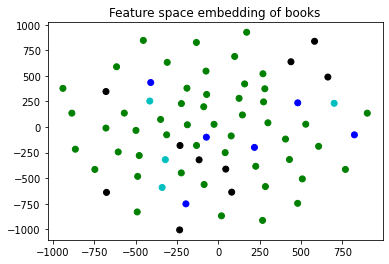

In [52]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colours)
plt.title('Feature space embedding of books');

#### Now we try looking for bigrams in the text:

In [53]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

In [54]:
all_text = ' '.join(documents)    

In [55]:
finder = BigramCollocationFinder.from_words(all_text.split())
#word_filter = lambda w1, w2: "he" in (w1, w2) or "she" in (w1, w2)
word_filter = lambda w1, w2: w1 != "he" and w1 != "she"
finder.apply_ngram_filter(word_filter)

bigram_measures = nltk.collocations.BigramAssocMeasures()
raw_freq_ranking = finder.nbest(bigram_measures.raw_freq, 20)

In [56]:
raw_freq_ranking

[('he', 'said'),
 ('he', 'wa'),
 ('she', 'said'),
 ('he', 'had'),
 ('he', 'could'),
 ('he', 'got'),
 ('he', 'did'),
 ('he', 'didn'),
 ('he', 'thought'),
 ('he', 'went'),
 ('she', 'wa'),
 ('he', 'took'),
 ('he', 'told'),
 ('he', 'would'),
 ('he', 'felt'),
 ('he', 'found'),
 ('he', 'see'),
 ('he', 'flew'),
 ('he', 'wanted'),
 ('he', 'called')]

### Now we try training a word embedding:

Note: spacy has default -PRON- lemma for pronouns. Repalce with original stirng?
https://stackoverflow.com/questions/56966754/how-can-i-make-spacy-not-produce-the-pron-lemma

In [57]:
import fasttext
import spacy
nlp = spacy.load('en_core_web_lg')

In [58]:
os.getcwd()

"/home/rustybilges/Documents/Work/Research/gender/Gender in Children's Literature/text_pdfs"

In [59]:
text_data = [' '.join(xi.replace('\n', ' ').split()) for xi in X]
text_data = '/n'.join(text_data)

In [60]:
# Remove all the special characters
document = re.sub(r'\W', ' ', text_data)

# remove all single characters
document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
# document = re.sub(r'\s+[a-zA-Z]\s+', ' ', str(X[sen]))

# Remove single characters from the start
document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

# Substituting multiple spaces with single space
document = re.sub(r'\s+', ' ', document, flags=re.I)

# Removing prefixed 'b'
document = re.sub(r'^b\s+', '', document)

# Converting to Lowercase
document = document.lower()

In [61]:
doc = nlp(document)

In [62]:
text_data = ' '.join([token.lemma_ if token.lemma_!='-PRON-' else token.orth_ for token in doc])

In [63]:
text_data

'a mouse take stroll through the deep dark wood fox see the mouse and the mouse look good where be you go to little brown mouse come and have lunch in my underground house it terribly kind of you fox but no m go to have lunch with gruffalo gruffalo what a gruffalo gruffalo why didn you know he have terrible tusk and terrible claws and terrible tooth in his terrible jaw where be you meet him here by these rock and his favourite food be roast fox roast fox m off fox say goodbye little mouse and away he speed silly old fox doesn he know there no such thing as gruffalo on go the mouse through the deep dark wood an owl see the mouse and the mouse look good where be you go to little brown mouse come and have tea in my treetop house it frightfully nice of you owl hut no m go to have tea with gruffalo gruffalo what a gruffalo gruffalo why didn you know he have knobbly knee and turn out toe and poisonous wart at the end of his nose where be you meeti ng him here by this stream and his favourite

In [65]:
len(text_data)

187084

In [70]:
len(text_data) * 2.8 / 4500000

0.11640782222222221

In [69]:
from collections import Counter
len(Counter(text_data.split(' ')))

3482

In [72]:
len(text_data) / 4500000

0.04157422222222222

In [73]:
3482/53628

0.06492876855374058

In [71]:
# Child-directed books data from Banaji has 98 books, ~45M total words, vocabulary of 53,628.

In [58]:
with open('../code/data.txt', 'w') as ofile:
    ofile.write(text_data)

In [59]:
model = fasttext.train_unsupervised('../code/data.txt', 
                                    #model='skipgram',
                                    model='cbow',
                                    dim=30,
                                    lr=0.2)

In [60]:
print("There are %d words in the vocabularly." % len(model.words))

'trowel' in model.words

There are 1004 words in the vocabularly.


False

#### Note: models does not seem to include all words in text...

In [61]:
'trowel' in text_data

True

#### But can still encode these words:

In [62]:
model['trowel']

array([-0.08393553,  0.19083698,  0.09757589,  0.15124726, -0.01700048,
       -0.19131207, -0.00133379, -0.06754062, -0.02693306, -0.22057591,
       -0.01694159,  0.05277558, -0.06570253, -0.15287608,  0.00671332,
        0.08356614,  0.23622714, -0.21251695,  0.20584825, -0.25826016,
        0.02628025,  0.08231465,  0.08850907,  0.09206193,  0.07444617,
        0.04909141,  0.02262963, -0.05892083, -0.03087487, -0.07088502],
      dtype=float32)

#### We can now measure cosine similarity between words and do prediction tasks:

Note: the embedding is highly sensitive to parameters (e.g. lr and dim), presumably because of the small volume of training data.

See: https://datascience-enthusiast.com/DL/Operations_on_word_vectors.html

In [63]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    
    ### START CODE HERE ###
    # Compute the dot product between u and v (≈1 line)
    dot = np.dot(u, v)
    # Compute the L2 norm of u (≈1 line)
    norm_u = np.sqrt(np.sum(u**2))
    
    # Compute the L2 norm of v (≈1 line)
    norm_v = np.sqrt(np.sum(v**2))
    # Compute the cosine similarity defined by formula (1) (≈1 line)
    cosine_similarity = dot / np.dot(norm_u, norm_v)
    ### END CODE HERE ###
    
    return cosine_similarity

In [64]:
print(cosine_similarity(model['mum'], model['dad']))
print(cosine_similarity(model['ladybird'], model['lazy']))
print(cosine_similarity(model['ladybird'], model['boy']))
print(cosine_similarity(model['ladybird'], model['dinosaur']))
print(cosine_similarity(model['aphid'], model['blue']))
print(cosine_similarity(model['wood'], model['blue']))

0.8833557
0.9042202
0.19535369
0.26680374
0.84612614
0.81008595


In [65]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    Performs the word analogy task as explained above: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """
    
    # convert words to lower case
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    # Get the word embeddings v_a, v_b and v_c (≈1-3 lines)
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    
    
    words = word_to_vec_map.words
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output

    # loop over the whole word vector set
    for w in words:        
        # to avoid best_word being one of the input words, pass on them.
        if w in [word_a, word_b, word_c] :
            continue
        
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)  (≈1 line)
        cosine_sim = cosine_similarity((e_b - e_a), (word_to_vec_map[w] - e_c))
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word (≈3 lines)
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        
    return best_word

In [66]:
complete_analogy('lazy', 'ladybird', 'bad-tempered', model)

'hey'

In [67]:
complete_analogy('girl', 'boy', 'woman', model)

'call'

In [68]:
complete_analogy('man', 'woman', 'boy', model)

'when'

In [69]:
complete_analogy('girl', 'answer', 'boy', model)

'spider'

In [70]:
print(cosine_similarity(model['man'], model['kitchen']))
print(cosine_similarity(model['woman'], model['kitchen']))

0.5374844
0.81896424


In [71]:
print(cosine_similarity(model['boy'], model['kitchen']))
print(cosine_similarity(model['girl'], model['kitchen']))

0.80182064
0.87414634


In [72]:
print(cosine_similarity(model['man'], model['office']))
print(cosine_similarity(model['woman'], model['office']))

0.58380616
0.8596437


In [73]:
print(cosine_similarity(model['dad'], model['work']))
print(cosine_similarity(model['mum'], model['work']))

0.5964515
0.75576776


In [74]:
print(cosine_similarity(model['boy'], model['adventure']))
print(cosine_similarity(model['girl'], model['adventure']))

0.7979761
0.87658566


In [75]:
print(cosine_similarity(model['he'], model['adventure']))
print(cosine_similarity(model['she'], model['adventure']))

0.413043
0.6489243


In [76]:
print(cosine_similarity(model['he'], model['her']))
print(cosine_similarity(model['she'], model['him']))

0.4272283
0.86279386


In [77]:
print(cosine_similarity(model['he'], model['is']))
print(cosine_similarity(model['she'], model['is']))

0.77196836
0.8262881


In [78]:
print(cosine_similarity(model['he'], model['go']))
print(cosine_similarity(model['she'], model['go']))

0.6711418
0.8506631


In [79]:
work_words = ['work', 'job', 'business', 'money']
home_words = ['home', 'house', 'baby', 'family']

In [80]:
for word in work_words + home_words:
    print(word, word in model.words)

work True
job True
business False
money True
home True
house True
baby True
family True


In [81]:
she_work = np.mean([cosine_similarity(model['she'], model[word]) for word in work_words])
she_home = np.mean([cosine_similarity(model['she'], model[word]) for word in home_words])

he_work = np.mean([cosine_similarity(model['he'], model[word]) for word in work_words])
he_home = np.mean([cosine_similarity(model['he'], model[word]) for word in home_words])

In [82]:
she_home - she_work

-0.41200703

In [83]:
he_home - he_work

-0.34935412

In [84]:
he_work

0.65179044

In [85]:
she_work

0.81597495

#### Trying WEFE to compute WEAT scores:

https://www.kdnuggets.com/2020/08/word-embedding-fairness-evaluation.html

Note: This package RNB, RNSB and MAC. It does not seem to provide the permutation test of statistical significance that is used in the Banaji paper.  

In [86]:
from wefe.utils import run_queries
from wefe.datasets import load_weat
from wefe import Query, WEAT, WordEmbeddingModel
from gensim.models import KeyedVectors
from gensim.models import FastText

# Load the sets used in the weat case study
weat_wordsets = load_weat()

/home/rustybilges/anaconda3/envs/genderenv/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [87]:
model.save_model("fasttextmodel.bin")

In [88]:
fast = FastText.load_fasttext_format("fasttextmodel.bin")#, 'FastText')

<ipython-input-88-68bd65db4c74>:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fast = FastText.load_fasttext_format("fasttextmodel.bin")#, 'FastText')
DEBUG:smart_open.smart_open_lib:{'uri': 'fasttextmodel.bin', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
INFO:gensim.models._fasttext_bin:loading 1004 words for fastText model from fasttextmodel.bin
DEBUG:gensim.utils:starting a new internal lifecycle event log for FastText
INFO:gensim.utils:FastText lifecycle event {'params': 'FastText(vocab=0, vector_size=30, alpha=0.025)', 'datetime': '2021-07-12T18:21:46.552694', 'gensim': '4.0.1', 'python': '3.9.4 (default, Apr  9 2021, 16:34:09) \n[GCC 7.3.0]', 'platform': 'Linux-5.4.0-77-gener

In [89]:
fast_ita = WordEmbeddingModel(fast.wv, 'fast')

In [90]:
female_identifiers =['she', 'girl', 'woman', 'mum', 'mother', 'lady', 'sister', 'daughter',
                   'girls', 'women', 'mums', 'mothers', 'ladies', 'sisters', 'daughters']

male_identifiers = ['he', 'boy', 'man', 'dad', 'father', 'guy', 'son',
                   'boys', 'men', 'dads', 'fathers', 'guys', 'brothers', 'sons']
# male_identifiers = ['he', 'boy', 'man', 'dad', 'father', 'guy', 'brother', 'son',
#                    'boys', 'men', 'dads', 'fathers', 'guys', 'brothers', 'sons']

work_words = ['work', 'job', 'money']
home_words = ['home', 'house', 'baby', 'family']


art_words = ['art', 'dance', 'dancing', 'sing', 'singing', 'paint', 'painting', 'song', 'draw', 'drawing']
science_words = ['science', 'scientist', 'chemistry', 'physics', 'engineer', 'space', 'spaceship', 'astronaut', 'chemical', 'microscope']

In [91]:
for word in art_words + science_words:
    print(word, word in model.words)

art False
dance True
dancing False
sing True
singing False
paint True
painting False
song True
draw True
drawing False
science False
scientist False
chemistry False
physics False
engineer False
space True
spaceship False
astronaut False
chemical False
microscope False


In [92]:
male_identifiers = [i for i in male_identifiers if i in model.words]
female_identifiers = [i for i in female_identifiers if i in model.words]

home_words = [i for i in home_words if i in model.words]
work_words = [i for i in work_words if i in model.words]

In [93]:
weat = WEAT()

In [94]:
gender_occupation_query = Query([male_identifiers, female_identifiers],
                                [work_words, home_words],
                                ['Male names', 'Female names'],
                                ['Work', 'Home'])

In [95]:
weat_results = weat.run_query(gender_occupation_query, fast_ita)

In [96]:
weat_results

{'query_name': 'Male names and Female names wrt Work and Home',
 'result': -0.23678383,
 'weat': -0.23678383,
 'effect_size': -0.19159506,
 'p_value': nan}

In [97]:
work_words

['work', 'job', 'money']

In [98]:
home_words

['home', 'house', 'baby', 'family']

In [99]:
male_identifiers

['he', 'boy', 'man', 'dad', 'father']

In [100]:
female_identifiers

['she', 'girl', 'mum', 'mother', 'lady']